# Keras_Vis Explainability 

This is a notebook to code ad-hoc score functions that are requested as input for the explainability methods that are presented on the keras_vis library.
There will be 2 sections:
<li> First one is about a binary clasification problem.
<li> Second one is about a 10 category classification problem.


## 1.- Binary Problem

### Initial imports

In [1]:
!nvidia-smi | grep "Tesla"

|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |


In [2]:
!pip install --upgrade tf-keras-vis tensorflow matplotlib

Requirement already up-to-date: tf-keras-vis in /usr/local/lib/python3.7/dist-packages (0.7.1)
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.5.0)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.7/dist-packages (3.4.2)


### Model creation and training. 

Most important part is where we convert the 0-9 categories into 2, from below five and greater than 5.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import cm
# Model / data parameters
num_classes = 2
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()


x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

print(" Converting MNIST into binary problem ")
y_train, y_test = np.array([1 if label >= 5 else 0 for label in y_train]), np.array([1 if label >= 5 else 0 for label in y_test])
# # convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()


batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose = 0)

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
 Converting MNIST into binary problem 
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1600)              0         
________

### Visualization Part

Only important part is at the begining, where we create our ad-hoc score function. We need to use here the real label of the things we are going to visualize, not the encoded variable.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


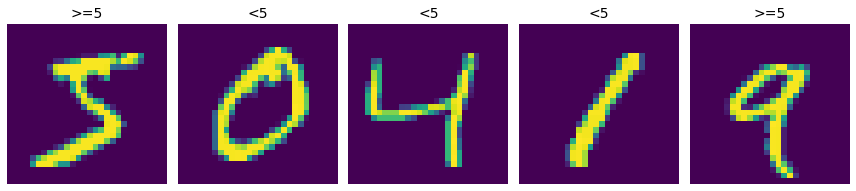

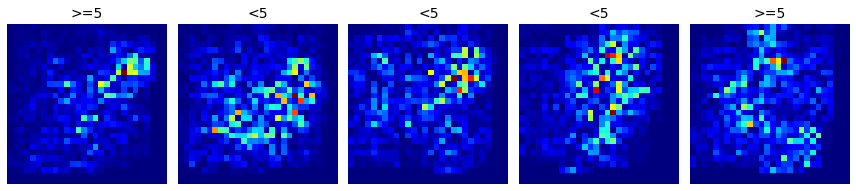

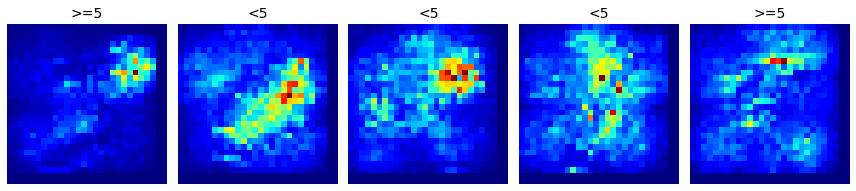

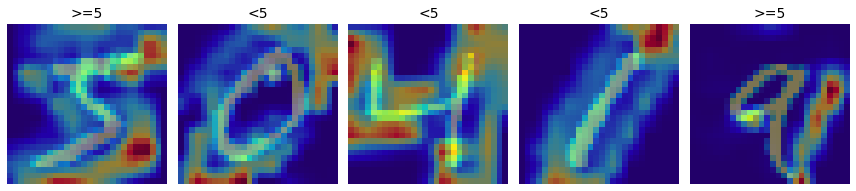

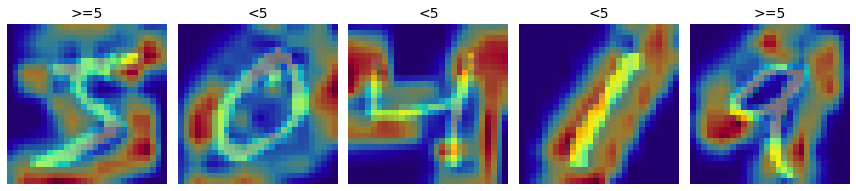

In [11]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score =  CategoricalScore([1, 0, 0, 0, 1])


from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()



# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

X = x_train[:5]
ncols = X.shape[0]
titles = ['>=5' if x == 1 else '<5' for x in model.predict_classes(X)]
# Generate saliency map
saliency_map = saliency(score, X)

f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(12, 4))
for i, title in enumerate(titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(X[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# Render
f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(12, 4))
for i, title in enumerate(titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()


saliency_map = saliency(score, X, smooth_samples=20, smooth_noise=0.20) 
f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(12, 4))

for i, title in enumerate(titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)
cam = gradcam(score,
              X,
              penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(12, 4))
for i, title in enumerate(titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(X[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

from tf_keras_vis.scorecam import Scorecam
## SCORECAM
scorecam = Scorecam(model)
cam = scorecam(score, X, penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(12, 4))
for i, title in enumerate(titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(X[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()


## 2.-Original MNIST problem

In [18]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
num_classes = 10

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# # convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()


#batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose = 0)

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1600)              0         
_______________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 --- Saliency Map --- 


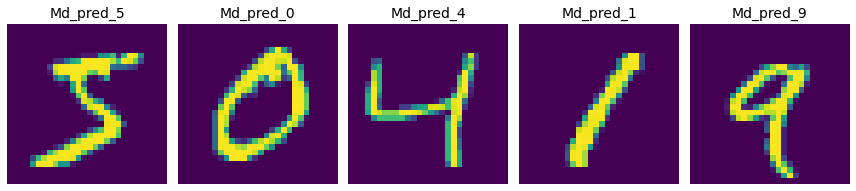

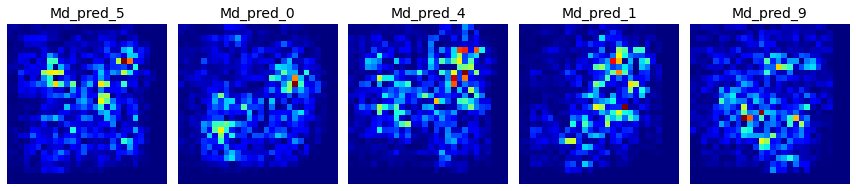

 --- Saliency Nosiy - Map --- 


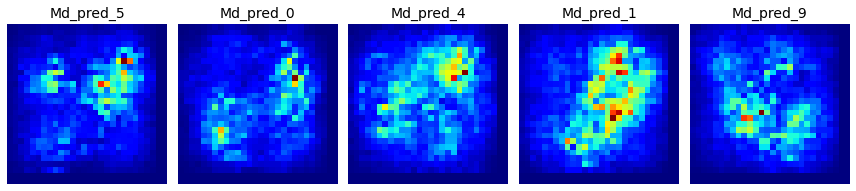

 --- Gradcam --- 


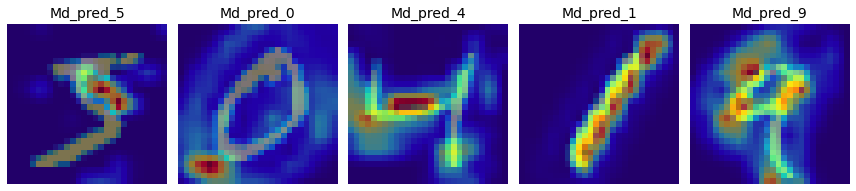

 --- ScoreCam --- 


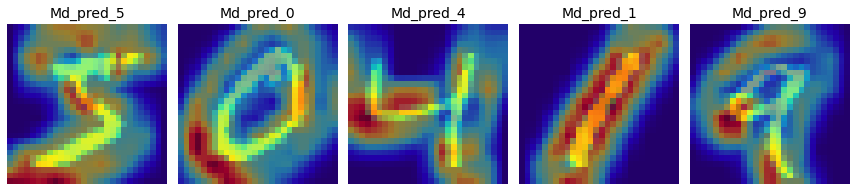

In [19]:
score =  CategoricalScore([5, 0, 4, 1, 9])

replace2linear = ReplaceToLinear()




saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

X = x_train[:5]
ncols = X.shape[0]
titles = ['Md_pred_' + str(result) for result in model.predict_classes(X)]

saliency_map = saliency(score, X)
print(" --- Saliency Map --- ")
f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(12, 4))
for i, title in enumerate(titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(X[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# Render
f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(12, 4))
for i, title in enumerate(titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

print(" --- Saliency Nosiy - Map --- ")
saliency_map = saliency(score, X, smooth_samples=20, smooth_noise=0.20) 
f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(12, 4))

for i, title in enumerate(titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()
print(" --- Gradcam --- ")
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)
cam = gradcam(score,
              X,
              penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(12, 4))
for i, title in enumerate(titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(X[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

print(" --- ScoreCam --- ")
scorecam = Scorecam(model)
cam = scorecam(score, X, penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(12, 4))
for i, title in enumerate(titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(X[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()


If we look at the results obtained maybe these can be a bit unexpected. For me at least they have been. I was expecting the same attention areas as a result of both models but these areas are much more detailed on the second model, the one that has to distinguish the 10 categories.
But the truth is that it makes sense the second model to have more areas because it needs to be much more fine-grained.